In [45]:
import numpy as np
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import sklearn.preprocessing as prep
import tensorflow as tf

from LstmVAE import LSTM_Var_Autoencoder
from LstmVAE import preprocess

name = '/home/mabbasloo/Documents/carData4/data/lbo/'
name1 = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/data/'

In [46]:
filename = '/home/mabbasloo/Desktop/Variational-Lstm-Autoencoder/list'

with open(filename) as f:
    data = f.readlines() 
data = [x.strip() for x in data]     
print (len(data), np.int(len(data)/60))
print (data[0])
print (data[len(data)-1])

12360 206
f001_S2000001_1.mat
f299_S2000001_60.mat


In [48]:
DATA = []
d = 10
db = h5py.File(name + data[0], 'r')
ds = db['Phi']
ds = np.asarray(ds).astype(np.float32).T
ds = ds[:, 0:d]
ds[np.isnan(ds)] = 0.0
ds[np.isinf(ds)] = 0.0
for i in range(20*60):
    #db = h5py.File(name + data[i], 'r')
    #ds = db['Phi']
    #ds = np.asarray(ds).astype(np.float32).T
    #ds = ds[:, 500-d:]
    #print (ds.shape)
    db1 = h5py.File(name1 + data[i], 'r')
    ds1 = db1['shape_xyz']
    ds1 = np.asarray(ds1).astype(np.float32)
    ds1[np.isnan(ds1)] = 0.0
    ds1[np.isinf(ds1)] = 0.0
    ds1[0] = ds1[0]/np.linalg.norm(ds1[0])
    ds1[1] = ds1[1]/np.linalg.norm(ds1[1])
    ds1[2] = ds1[2]/np.linalg.norm(ds1[2])    
    DATA.append(np.dot(ds1, ds))
print (len(DATA), DATA[0].shape)

def standard_scale(X_train):
    for i in range(len(X_train)):
        X_train[i] = X_train[i]/np.linalg.norm(X_train[i], 'fro')
    return X_train

DATA = standard_scale(DATA)

1200 (3, 10)


Text(0.5, 0, 'z')

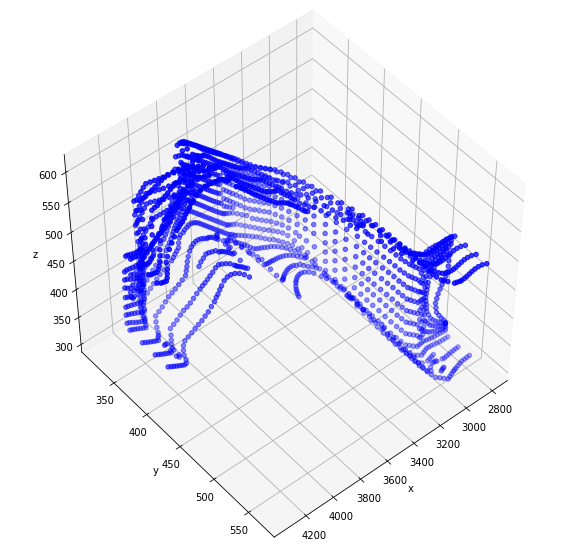

In [49]:
db1 = h5py.File(name1 + data[0], 'r')
ds1 = db1['shape_xyz']
ds1 = np.asarray(ds1).astype(np.float32)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(ds1[0], ds1[1], ds1[2], c='b', marker='o')
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

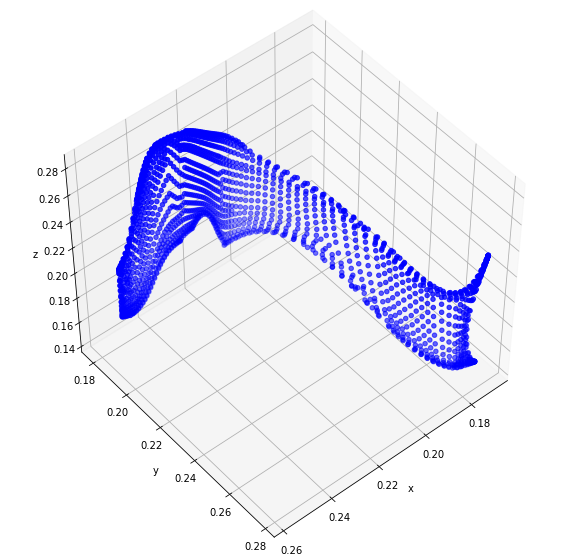

In [50]:
xyz = np.dot(DATA[0], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

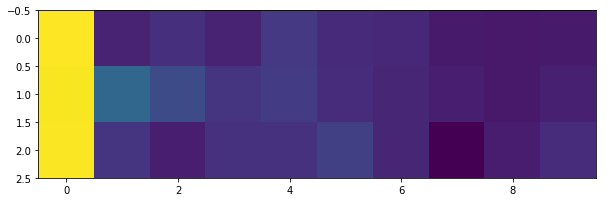

In [51]:
plt.figure(figsize=(10, 10)); 
plt.imshow(DATA[0])

In [53]:
vae = LSTM_Var_Autoencoder(intermediate_dim = 10, z_dim = 3, n_dim=d, stateful = False) #default stateful = False

vae.fit(DATA[0:10*60], learning_rate=0.001, batch_size = 10, num_epochs = 100, opt = tf.train.AdamOptimizer, REG_LAMBDA = 0.01, grad_clip_norm=10, optimizer_params=None, verbose = True)



Training...


Epoch   1    Loss 0.03257
Epoch   11   Loss 0.00193
Epoch   21   Loss 0.00012
Epoch   31   Loss 0.00002
Epoch   41   Loss 0.00001
Epoch   51   Loss 0.00000
Epoch   61   Loss 0.00000
Epoch   71   Loss 0.00000
Epoch   81   Loss 0.00000
Epoch   91   Loss 0.00000


Training time 0.83 minutes


In [54]:
x_reconstructed, recons_error = vae.reconstruct(DATA[10*60:11*60], get_error = True) #returns squared error

x_reduced = vae.reduce(DATA[0:11*60]) #latent space representation

Text(0.5, 0, 'latent 3')

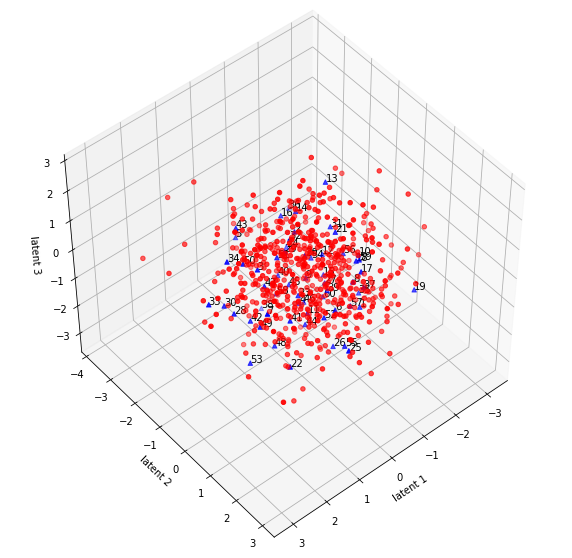

In [55]:
fig = plt.figure(figsize=(10, 10))
c = ['r', 'b']
m = ['o', '^']
label = []
for i in range(1, 60+1):
    label.append(np.str(i))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_reduced[0:10*60, 0], x_reduced[0:10*60, 1], x_reduced[0:10*60, 2], c=c[0], marker=m[0])
ax.scatter(x_reduced[10*60:11*60, 0], x_reduced[10*60:11*60, 1], x_reduced[10*60:11*60, 2], c=c[1], marker=m[1])
ii = 0
for i in range(10*60, 11*60):
    ax.text(x_reduced[i, 0], x_reduced[i, 1], x_reduced[i, 2], label[ii], size=10, zorder=1, color='k') 
    ii += 1
ax.view_init(50, 50)
ax.set_xlabel('latent 1')
ax.set_ylabel('latent 2')
ax.set_zlabel('latent 3')

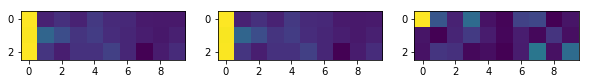

In [56]:
plt.figure(figsize=(10, 30)); 
plt.subplot(1,3,1); plt.imshow(x_reconstructed[0])
plt.subplot(1,3,2); plt.imshow(DATA[10*60])
plt.subplot(1,3,3); plt.imshow(np.abs(x_reconstructed[0] - DATA[10*60]))

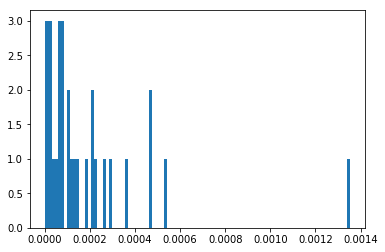

In [57]:
_,_,_ = plt.hist(np.abs(x_reconstructed[0] - DATA[10*60]).reshape((3*d)), bins=100)

(3, 1714)


Text(0.5, 0, 'z')

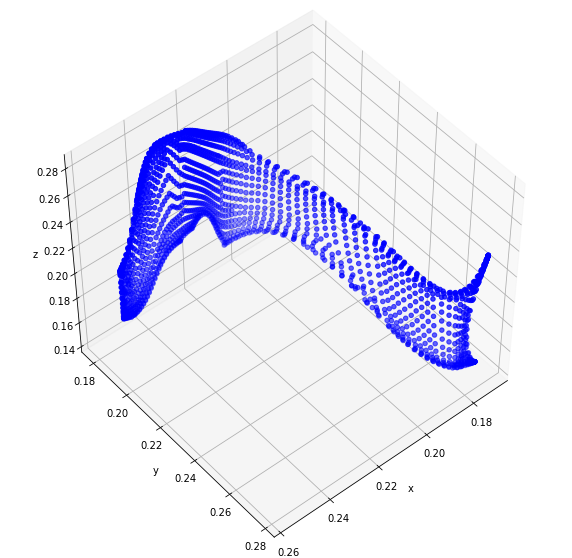

In [58]:
xyz= np.dot(DATA[10*60], np.linalg.pinv(ds))
print (xyz.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['o', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[0], xyz[1], xyz[2], c=c[0], marker=m[0])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

(3, 1714)


Text(0.5, 0, 'z')

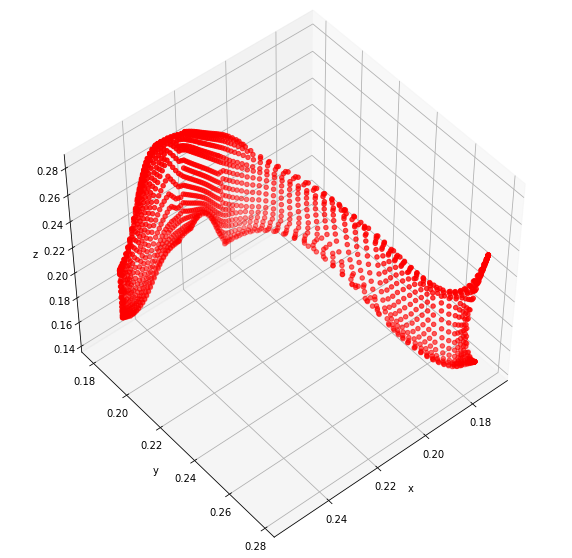

In [59]:
xyz_reconstructed = np.dot(x_reconstructed[0], np.linalg.pinv(ds))
print (xyz_reconstructed.shape)
fig = plt.figure(figsize=(10, 10))
c = ['b', 'r']
m = ['^', 'o']
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz_reconstructed[0], xyz_reconstructed[1], xyz_reconstructed[2], c=c[1], marker=m[1])
ax.view_init(50, 50)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')